# CORD-19 citation network analysis

In this notebook, we build a bibliographic coupling citation network of CORD-19 publications, using Dimensions data, and perform clustering using the Leiden algorithm.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, time, pickle
import ujson as json
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

In [4]:
# dataset Dimensions: source of citation data

json_sources = "datasets_output/json_dimensions_cwts"

In [5]:
# get the list of DOIs to filter papers in CORD-19

cord_19_dois = pickle.load(open("datasets_output/networks/cord-19-dois.pk","rb"))

In [204]:
# build networks and node metadata
from collections import OrderedDict
import sys

metadata = list()
metadata_dict = dict()
citations = OrderedDict()
total_publications = 0

for root, dirs, files in os.walk(json_sources):
    for f in files:
        all_data = codecs.open(os.path.join(root,f),encoding='latin1').read()
        for line in all_data.split("\n"):
            total_publications += 1
            if line:
                try:
                    data = json.loads(line)
                    if "doi" in data.keys() and data["doi"] in cord_19_dois: # filter by DOIs in CORD-19
                        if "references" in data.keys() and len(data["references"])>0: # filter out papers without outbound citations
                            title = ""
                            year = ""
                            doi = ""
                            times_cited = ""
                            journal = ""
                            if "title" in data.keys() and data["title"]:
                                title = data["title"].replace('"',"")
                            if "journal" in data.keys() and "title" in data["journal"].keys() and data["journal"]["title"]:
                                jorunal = data["journal"]["title"]
                            if "year" in data.keys() and data["year"]:
                                year = str(data["year"])
                            if "doi" in data.keys() and data["doi"]:
                                doi = data["doi"]
                            if "times_cited" in data.keys():
                                times_cited = str(data["times_cited"])
                            metadata.append((data["id"],'"'+title+'"',year,'"'+doi+'"','"'+journal+'"',times_cited))
                            metadata_dict[data["id"]] = {"title":title,"year":year,"doi":doi,"journal":journal,"times_cited":times_cited}
                            citations[data["id"]] = data["references"]
                except ValueError:
                    print("Could not convert data.")
                except:
                    print(line)
                    continue

Could not convert data.


In [205]:
len(citations)

38754

In [6]:
len(cord_19_dois)

43956

In [206]:
total_publications

50033

In [ ]:
# therefore:
print("Not in CORD-19 "+str(total_publications-len(cord_19_dois)))
print("Without citations "+str(len(cord_19_dois)-len(citations)))

In [207]:
# create directed network

In [208]:
# create bibc network
# this is a super naive method, and takes a while

bibc_edge_list = list()
items = [(k,v) for k,v in citations.items()]

for n,(k1,v1) in tqdm(enumerate(items)):
    for k2,v2 in items[n+1:]:
        edge_weight = len(set(v2).intersection(set(v1))) / len(set(v2).union(set(v1))) # fractional edge weight
        if edge_weight > 0:
            bibc_edge_list.append((k1,k2,str(edge_weight)))

In [209]:
# export csv

with open("datasets_output/networks/bib_coupling_sources_cord19_doi_edgelist_norm.csv","w") as f:
    f.write("Source,Target,Weight\n")
    for edge in bibc_edge_list:
        #if float(edge[2])>1:
        f.write(",".join(edge)+"\n")

In [210]:
with open("datasets_output/networks/bib_coupling_sources_cord19_doi_nodelist.csv","w") as f:
    f.write("Id,Title,Year,DOI,Journal,Times_cited\n")
    for node in metadata:
        f.write(",".join(node)+"\n")

In [211]:
len(bibc_edge_list)

11781927

In [212]:
weight_list = [float(x[2]) for x in bibc_edge_list if float(x[2])>0]

In [213]:
np.median(weight_list)

0.0136986301369863

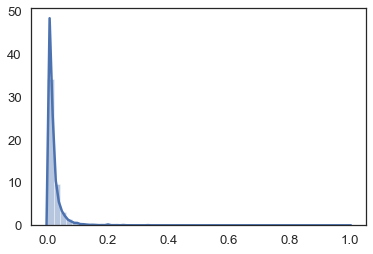

In [214]:
sns.distplot(weight_list)

In [215]:
import igraph as ig

In [216]:
g = ig.Graph()

In [217]:
edges = [(int(k[0].replace("pub.","")),int(k[1].replace("pub.",""))) for k in bibc_edge_list]
nodes = list(set([k[0] for k in edges]).union(set([k[1] for k in edges])))
weights = [float(k[2]) for k in bibc_edge_list]

In [218]:
# mapping of nodes to identifiers for this stupud igraph to work

node_map = {k:n for n,k in enumerate(nodes)}
edges_int = [(node_map[k[0]],node_map[k[1]]) for k in edges]
nodes_int = [node_map[k] for k in nodes]

In [219]:
len(node_map)

38290

In [220]:
"There are "+str(len(citations)-len(node_map))+" disconnected publications (with references)"

'There are 464 disconnected publications (with references)'

In [221]:
inverse_node_map = {n:k for k,n in node_map.items()}

In [222]:
g.add_vertices(nodes_int)
g.add_edges(edges_int)
g.es["weight"] = weights

In [223]:
import leidenalg as la

In [224]:
# 0.05 seems to find a relatively high modularity and reasonable sized clusters. Lowering it brings up one or two large clusters.

partition = la.find_partition(g, la.CPMVertexPartition, resolution_parameter = 0.05)

In [225]:
partition.quality()

11581408.800000027

In [226]:
partition.q

0.29706581071277316

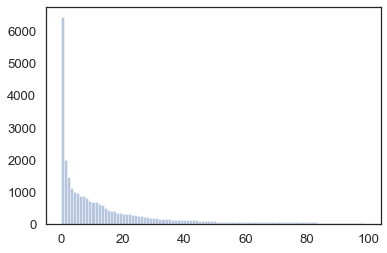

In [227]:
sns.distplot([x for x in partition.membership if x<100], norm_hist=False, kde=False, bins=100)

In [228]:
from collections import Counter

c = Counter(partition.membership)

In [229]:
len(c)

1601

In [230]:
c.most_common(10)

[(0, 6434),
 (1, 1995),
 (2, 1475),
 (3, 1127),
 (4, 999),
 (5, 987),
 (6, 879),
 (7, 877),
 (8, 807),
 (9, 714)]

In [271]:
which_cluster = 0
pubs_zero = ["pub."+str(inverse_node_map[n]) for n,x in enumerate(partition.membership) if x==which_cluster]

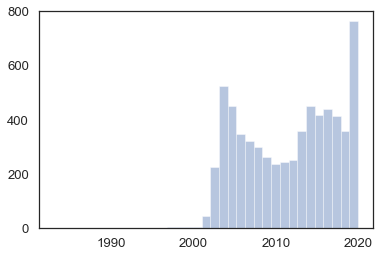

In [272]:
sns.distplot([int(metadata_dict[p]["year"]) for p in pubs_zero], kde=False)

In [234]:
clusters = dict()

for m in range(len(c)):
    clusters[m] = [metadata_dict["pub."+str(inverse_node_map[n])]["doi"] for n,x in enumerate(partition.membership) if x==m]

In [235]:
import pickle
pickle.dump(clusters,open("datasets_output/networks/clusters_doi.pk","wb"))

In [241]:
# create network of clusters
from collections import defaultdict

cluster_size_limit = 99

node_to_cluster_map = {n:cl for n,cl in enumerate(partition.membership) if c[cl]>cluster_size_limit} #focus only on clusters with 100+ papers

edges_clusters_int = defaultdict(float)
edges_clusters_count = defaultdict(float) # this is used to average

for e,w in zip(edges_int,weights):
    if e[0] in node_to_cluster_map.keys() and e[1] in node_to_cluster_map.keys():
        if node_to_cluster_map[e[0]] != node_to_cluster_map[e[1]]: #only consider weights across clusters
            edges_clusters_int[tuple(sorted([node_to_cluster_map[e[0]],node_to_cluster_map[e[1]]]))] += w
            edges_clusters_count[tuple(sorted([node_to_cluster_map[e[0]],node_to_cluster_map[e[1]]]))] += 1

In [242]:
len(node_map)

38290

In [243]:
len(node_to_cluster_map)

26510

In [244]:
len(edges_clusters_int.keys())

1072

In [245]:
# export edges and nodes for the cluster network

with open("datasets_output/networks/cluster_bibc_nodes.csv","w") as f:
    f.write("Id,Size\n")
    for nc,s in c.items():
        if s>cluster_size_limit:
            f.write(",".join([str(nc),str(s)])+"\n")
        
with open("datasets_output/networks/cluster_bibc_edges.csv","w") as f:
    f.write("Source,Target,Weight\n")
    for nc,w in edges_clusters_int.items():
        f.write(",".join([str(nc[0]),str(nc[1]),str(w/edges_clusters_count[nc])])+"\n") # relative edge weights
        #f.write(",".join([str(nc[0]),str(nc[1]),str(w)])+"\n") # absolute edge weights